In [1]:
from set_math import *

sympy imported
pandas imported
numpy imported
scipy imported


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


statsmodels imported
statsmodels.formula imported
statasmodels.stats.api imported


In [2]:
from set_visualization import *

matplotlib imported
pyplot imported
seaborn imported
sns.set
sns.set_style(whitegrid)
sns.set_color_codes()
type (% matplotlib inline) if necessary
type (% config InlineBackend.figure_formats = {‘png’, ‘retina’}) if necessary


# load dataset

train2.csv 파일 경로 : dss7-walmart-project/model_generation/wy

In [4]:
df = pd.read_csv('../model_generation/wy/train2.csv', index_col=0)

In [5]:
print(df.shape)

(118694, 26)


In [7]:
def make_year(date):
    return int(date.split('-')[0])

def make_month(date):
    return int(date.split('-')[1])

def make_day(date):
    return int(date.split('-')[2])

def make_monthday(date):
    return (date.split('-')[1:3])

def dayofweek_num(dayofweek):
    if dayofweek == 'Mon':
        return 1
    elif dayofweek == 'Tue':
        return 2
    elif dayofweek == 'Wed':
        return 3
    elif dayofweek == 'Thi':
        return 4
    elif dayofweek == 'Fri':
        return 5
    elif dayofweek == 'Sat':
        return 6
    elif dayofweek == 'Sun':
        return 7

In [8]:
df['year'] = df['date'].apply(make_year)
df['month'] = df['date'].apply(make_month)
df['day'] = df['date'].apply(make_day)
df['dayofweek'] = df['dayofweek'].apply(dayofweek_num)
df['dayofweek'] = df['dayofweek'].astype(int)

In [6]:
## 분포 그리기
# fig = plt.figure(figsize=(20, 15))
# for i in range(0,30):
#     plt.subplot(10, 3, i+1)
#     plt.hist(df[df.columns[i]], bins=50)
#     plt.xlabel(df.columns[i], fontsize = 20)
# plt.tight_layout()

# 카테고리형 독립변수만 고려

In [9]:
model_1 = sm.OLS.from_formula('np.log(units) ~ C(item_nbr) + C(store_nbr) + C(dayofweek) + C(year) + C(month) + C(day)', data=df)
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     3600.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:26:52   Log-Likelihood:            -1.0428e+05
No. Observations:              118694   AIC:                         2.090e+05
Df Residuals:                  118490   BIC:                         2.109e+05
Df Model:                         203                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.1059      0

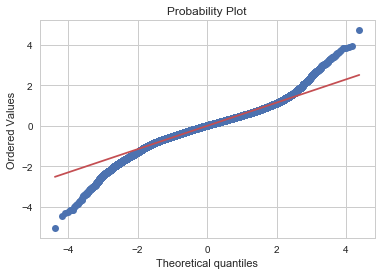

In [10]:
sp.stats.probplot(result_1.resid, plot=plt)
plt.show()

# Leverage & Outlier 제거 작업

In [11]:
df_test = df

In [12]:
influence = result_1.get_influence()
influence

### Cook's Distance 를 통한 leverage, outlier 구하기


In [13]:
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(df['units']) - 2)
drop_idx = np.where(cooks_d2 > fox_cr)[0]
len(drop_idx)

7551

### 해당 leverage&outlier 제외

In [14]:
df_test.drop(list(drop_idx),inplace=True)

In [15]:
df_test.reset_index(drop=True, inplace=True)

# 쿡스디스턴스를 통한 아웃라이어 제거 후

In [17]:
model_1 = sm.OLS.from_formula('np.log(units) ~ C(item_nbr) + C(store_nbr) + C(dayofweek) + C(year) + C(month) + C(day)', data=df_test)
result_1 = model_1.fit()
print(result_1.summary())

                            OLS Regression Results                            
Dep. Variable:          np.log(units)   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     5413.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        17:28:42   Log-Likelihood:                -71935.
No. Observations:              111143   AIC:                         1.443e+05
Df Residuals:                  110939   BIC:                         1.462e+05
Df Model:                         203                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0662      0

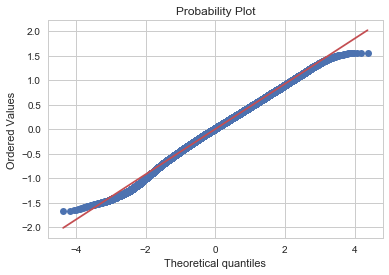

Chi^2       : 680.633
P-value     :  0.000


In [18]:
sp.stats.probplot(result_1.resid, plot=plt)
plt.show()

test = sms.omni_normtest(result_1.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

개선 됨을 볼 수 있다. 하지만 이 과정을 반복 한다고 해서 더 좋아지지는 않았다.

여전히 잔차의 정규성은 볼 수 없음

# 정규화 (sci-kit learn)

In [21]:
from sklearn.datasets import make_regression
from patsy import dmatrices
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

In [22]:
# patsy를 통한 formula 생성
y, X = dmatrices( "np.log(units) ~ C(item_nbr) + C(store_nbr) + C(dayofweek) + C(year) + C(month) + C(day)", df_test , return_type = 'dataframe' )

In [23]:
# Linear Regression, Ridge, Lasso, ElasticNet
model1_LR = LinearRegression().fit(X, y)
model1_ridge = Ridge(alpha=0.01).fit(X, y)
model1_lasso = Lasso(alpha=0.01).fit(X, y)
model1_EN = ElasticNet(alpha=0.01).fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [24]:
from sklearn.model_selection import KFold

cv = KFold(10, shuffle=True)
#cross_val_score(model1_LR, X, y, scoring="r2", cv=cv)
print('[Original LR]')
print('score : ', cross_val_score(model1_LR, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_LR, X, y, scoring="r2", cv=cv)),'\n')

print('[Ridge]')
print('score : ', cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv)),'\n')
      #'std : ', np.std(cross_val_score(model1_ridge, X, y, scoring="r2", cv=cv)))

print('\n[Lasso]')
print('score : ', cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv)),'\n')
      #'std : ', np.std(cross_val_score(model1_lasso, X, y, scoring="r2", cv=cv)))

print('\n[Elastic-net]')
print('score : ', cross_val_score(model1_EN, X, y, scoring="r2", cv=cv),'\n',
      'mean : ', np.mean(cross_val_score(model1_EN, X, y, scoring="r2", cv=cv)),'\n')
#      'std : ', np.std(cross_val_score(model1_EN, X, y, scoring="r2", cv=cv)))

[Original LR]
score :  [ 0.90878393  0.90746207  0.90931093  0.90666502  0.90549921  0.91046388
  0.91092029  0.90411239  0.90692539  0.90952826] 
 mean :  0.907921169283 

[Ridge]
score :  [ 0.90878609  0.90474634  0.90795845  0.9107903   0.90697986  0.9104346
  0.90854499  0.90768176  0.90684806  0.9067054 ] 
 mean :  0.907963513161 


[Lasso]
score :  [ 0.70775777  0.70175431  0.71029396  0.70367364  0.70588228  0.7096821
  0.70929549  0.71508927  0.71156238  0.70757187] 
 mean :  0.70823950351 


[Elastic-net]
score :  [ 0.72400194  0.72134558  0.72192188  0.7250227   0.72324699  0.72965905
  0.72037671  0.72519779  0.72643617  0.7240565 ] 
 mean :  0.724185648716 



### 우리 모델은 Lasso, Elastic-Net하면 망하는가보오...

# 모델에 제출하기에 앞선 cross-validation 결과 및 RMSLE 채점 결과

In [25]:
# RMSLE 구현 / 긁어왔습니다 
from sklearn.metrics import make_scorer
def rmsle(predict, actual):
    predict = np.array(predict)
    actual = np.array(actual)
    
    log_predict = np.log(predict + 1)
    log_actual = np.log(actual + 1)
    
    difference = log_predict - log_actual
    square_difference = difference ** 2
    mean_square_difference = square_difference.mean()
    
    score = np.sqrt(mean_square_difference)
    
    return score

rmsle_score = make_scorer(rmsle)
rmsle_score

make_scorer(rmsle)

In [26]:
y, X = dmatrices('np.log(units) ~ C(item_nbr) + C(store_nbr) + C(dayofweek)', df_test, return_type = 'dataframe')

model_LR = LinearRegression().fit(X, y)
model_ridge = Ridge().fit(X, y)
model_lasso = Lasso().fit(X, y)
model_EN = ElasticNet().fit(X, y)

In [27]:
cross_val_score(model_ridge, X, y, cv=10, scoring=rmsle_score).mean()

0.28410331641112269

최종 제출 시, 0.284점 예상

model_LR으로 테스트 할 때는 채점이 되지 않는 이유, 아직 모르겠습니다

0.1점대 밑으로 갈 생각을 안 허네요

# 제출을 위한 test파일 준비

### test file preprocessing

In [ ]:
test = pd.read_csv('../../data/basic/test.csv')
print(test.shape)
test.head()

In [ ]:
key = pd.read_csv('../../data/basic/key.csv')
weather = pd.read_csv('../../data/weather_v8_with_holiday.csv')

In [ ]:
test = pd.merge(test, key)

In [ ]:
test = pd.merge(test, weather)

In [ ]:
test.columns

In [ ]:
test = pd.DataFrame(test, columns=['date','dayofweek', 'is_holiday', 'store_nbr', 'item_nbr', 'station_nbr', 'tmax',
       'tmin', 'tavg', 'depart', 'dewpoint', 'wetbulb', 'heat', 'cool',
       'sunrise', 'sunset', 'codesum', 'codesum_YN', 'snowfall', 'preciptotal',
       'stnpressure', 'sealevel', 'resultspeed', 'resultdir', 'avgspeed',
       ])

In [ ]:
test.head()

In [ ]:
def is_holiday(holiday):
    if holiday == 'holiday':
        return 1
    elif holiday == 'holiday_work':
        return 1
    elif holiday == "workday":
        return 0

In [ ]:
test['is_holiday'] = test['is_holiday'].apply(is_holiday)

In [ ]:
test['year'] = test['date'].apply(make_year)
test['month'] = test['date'].apply(make_month)
test['day'] = test['date'].apply(make_day)
test['dayofweek'] = test['dayofweek'].apply(dayofweek_num)

In [ ]:
test_sample = test.drop(columns=['date', 'tmax', 'tmin', 'tavg', 'dewpoint', 'wetbulb',
       'sunrise', 'sunset','depart',  'codesum', 'codesum_YN', 'snowfall',
       'stnpressure', 'sealevel','resultdir', 'avgspeed',
       'station_nbr', 'heat', 'cool', 'preciptotal', 'is_holiday', 'resultspeed'])

In [ ]:
test_sample.head()

In [ ]:
test_X_df = pd.DataFrame(columns=['item_nbr', 'store_nbr','dayofweek', 'year', 'month', 'day'])

for nbr in range(1, 45+1):
    store_nbr = df_test[df_test['store_nbr'].isin([nbr])]
    sold_item_list = list(store_nbr['item_nbr'].unique())
    sold_item_list

    test_store_nbr = test_sample[test_sample['store_nbr'].isin([nbr])]
    to_test_df = test_store_nbr[test_store_nbr['item_nbr'].isin(sold_item_list)]

    test_X_df = pd.concat([test_X_df, to_test_df], axis = 0)
    
test_X_df.shape

In [ ]:
test_X_df.head()

In [ ]:
test_X_df['store_nbr'] = test_X_df['store_nbr'].astype(int)
test_X_df['item_nbr'] = test_X_df['item_nbr'].astype(int)
test_X_df['year'] = test_X_df['year'].astype(int)
test_X_df['month'] = test_X_df['month'].astype(int)
test_X_df['day'] = test_X_df['day'].astype(int)
test_X_df['dayofweek'] = test_X_df['dayofweek'].astype(object)

In [ ]:
test_result = result_ridge.predict(test_X_df)

### create submission file

In [ ]:
result = pd.concat([test, test_result], axis=1)

In [ ]:
print(result.shape)
result.head()

In [ ]:
result['units'] = result[0]

In [ ]:
def itiszero(units):
    if units > 0:
        return units
    else:
        return 0

In [ ]:
result['units'] = result['units'].apply(itiszero)

In [ ]:
result['units'] = result['units'].astype(int)

In [ ]:
result = pd.DataFrame(data=result, columns=['store_nbr', 'item_nbr', 'date', 'units'])

In [ ]:
for col in result[['store_nbr', 'item_nbr']]:
    result[col] = result[col].astype(int)

In [ ]:
result['id'] = result['store_nbr'].astype(str)+'_'+result['item_nbr'].astype(str)+'_'+result['date'].astype(str)

In [ ]:
for_submission = result.loc[:,['id','units']]

In [ ]:
for_submission.head()

In [ ]:
for_submission.to_csv('submission_sample7.csv', index=False)

# samplesubmission3
### dayofweek , outlier 5번 제거 ==> 캐글 0.26513
 


 
# samplesubmission4
### dayofweek, year, month, day , outlier 5번 제거 ==> 캐글 0.25870

# samplesubmission5

### dayofweek, year, month, day, np.log(units) / outlier 5번 제거 ==> 캐글 0.33 (CV 결과도 좋지 않았음)

# samplesubmission6

### dayofweek, year, month, day, np.log(units) / cook's distance로 3번 제거 ==> 캐글 0.33

# samplesubmission7

### dayofweek, year, month, day, np.log(units) / cook's distance로 3번 제거, ridge 정규화 ==> 캐글 0.33 (CV 결과가 좋은 Ridge로 적용)